In this notebook, the precomputed results from the notebook "The order of the test rows 2" are used to reconstruct an approximate order in the new test DataFrame.

In [1]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

In [2]:
def preprocess_data(raw_df):
    assert len(raw_df.shape) == 2

    y = raw_df['label'].to_numpy()
    assert y.shape == (raw_df.shape[0],)

    cols = [
        'X239', 'X743', 'X215', 'X623', 'X240', 'X71', 'X119', 'X157',
        'X173', 'X198', 'X113', 'X324', 'X366', 'X462',
    ]

    df = raw_df[cols]
    assert df.isna().sum().sum() == 0

    df = pd.concat([
        df.shift(-lag).add_suffix(f'_lead_{lag}')
        for lag in [30, 40, 50, 60, 70, 80]
    ], axis=1)

    df = df.fillna(0.0)
    assert 'label' not in df.columns
    assert raw_df.shape[0] == df.shape[0] and (raw_df.index == df.index).all()
    assert df.isna().sum().sum() == 0
    assert df.shape[0] == y.shape[0]
    return df, y

In [3]:
train_df = pd.read_parquet('/kaggle/input/drw-crypto-market-prediction/train.parquet')
X_train, y_train = preprocess_data(train_df)
train_df = None
print(X_train.shape, y_train.shape)

(525886, 84) (525886,)


In [4]:
scaler = StandardScaler()
X_train.iloc[:, :] = scaler.fit_transform(X_train)

In [5]:
%%time

model = Ridge()
model.fit(X_train, y_train)

CPU times: user 602 ms, sys: 126 ms, total: 728 ms
Wall time: 583 ms


Ridge()

<Axes: >

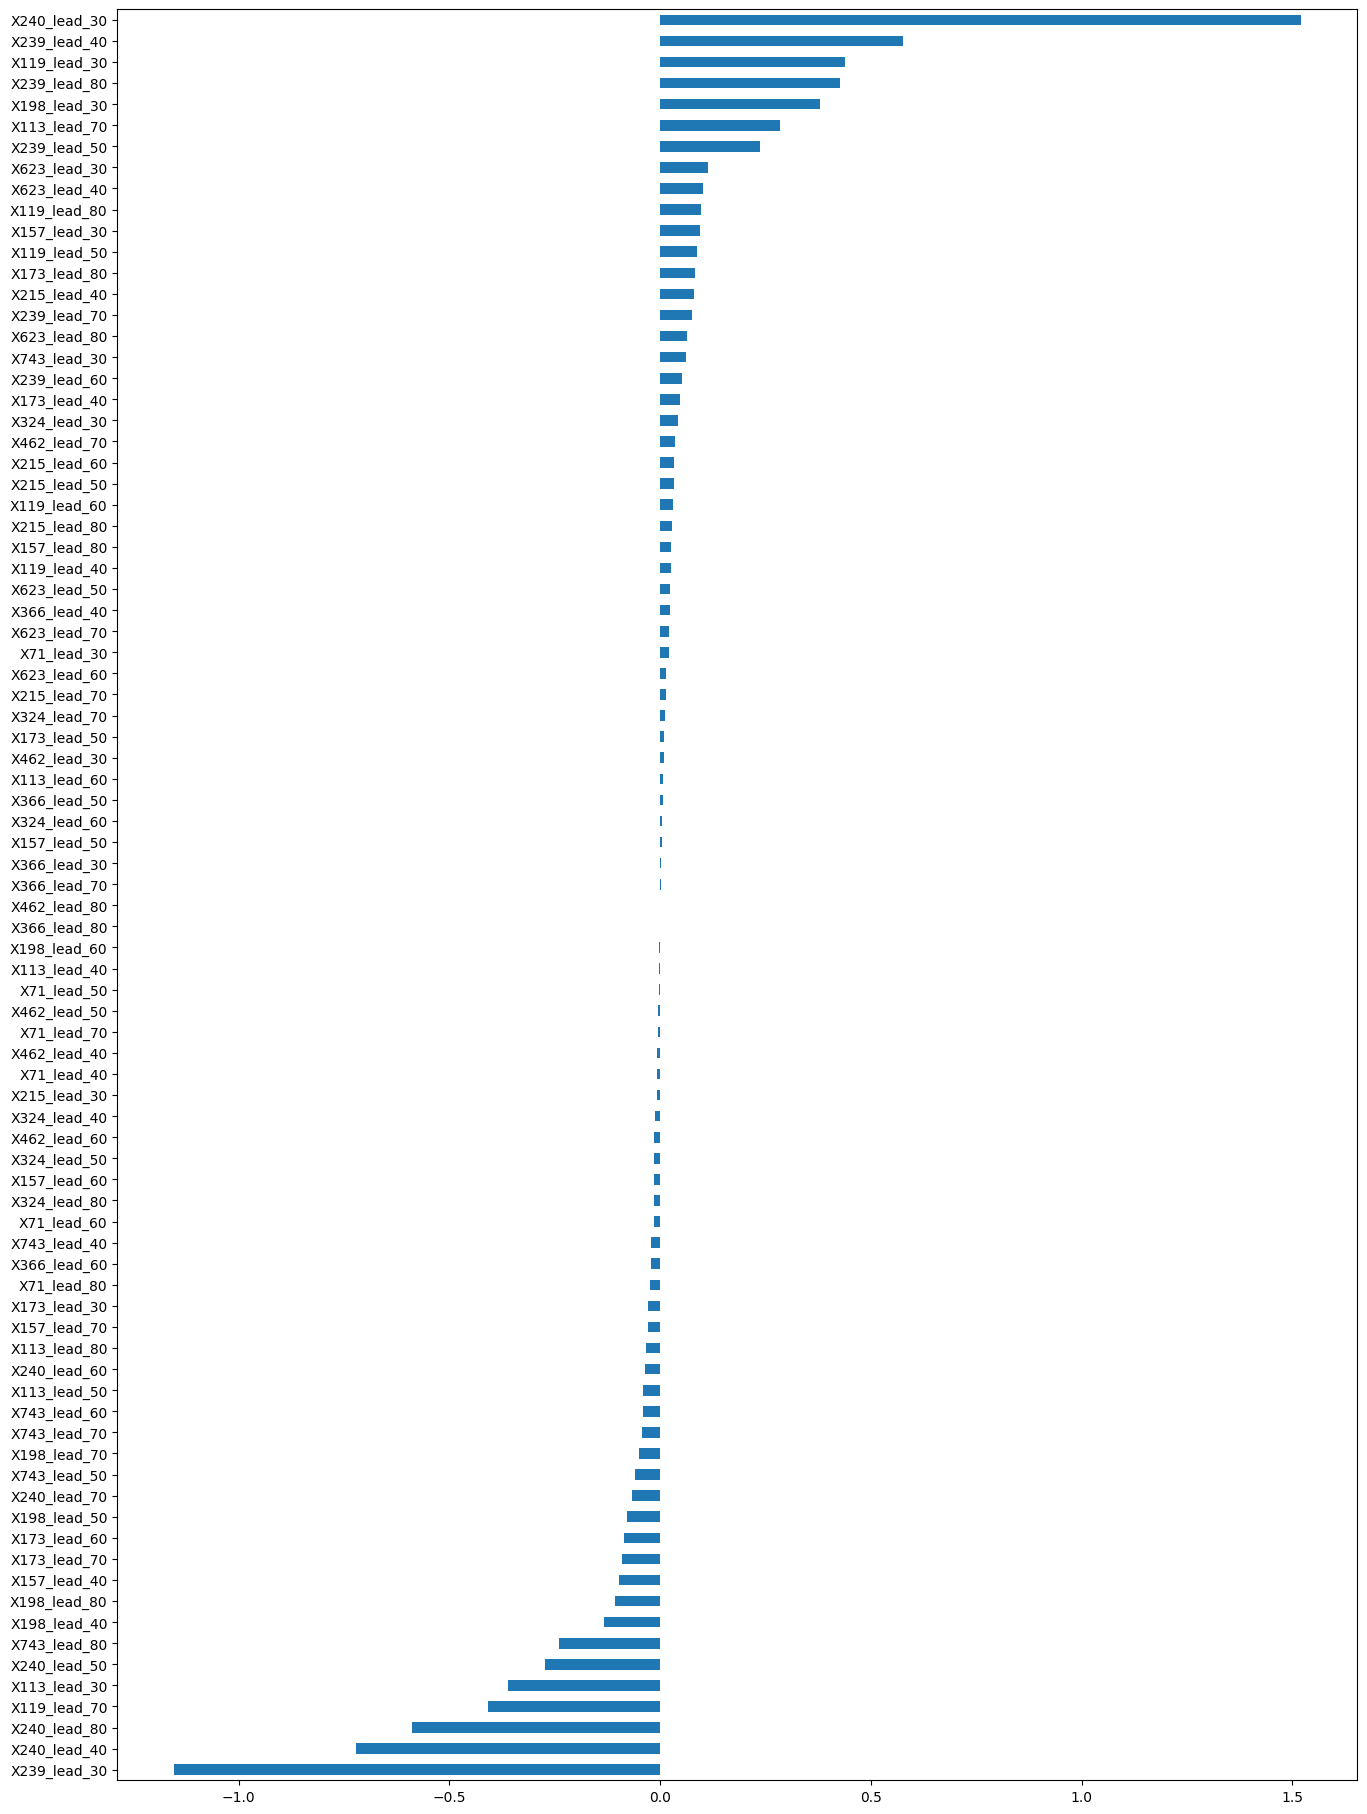

In [6]:
pd.Series(model.coef_, index=model.feature_names_in_).sort_values().plot(
    kind='barh', figsize=(16, 2 + len(model.coef_) // 4)
)

In [7]:
X_train = None
y_train = None

In [8]:
test_df = pd.read_parquet('/kaggle/input/drw-crypto-market-prediction/test.parquet')

Let's explore a bit the precomputed array:

In [9]:
t = pd.Series(pd.read_csv(
    '/kaggle/input/the-order-of-the-test-rows-2/closest_rows.csv'
)['0'].to_numpy())
assert t.shape == (test_df.shape[0],)
print('Reconstructed timestamps share:', len(t[t >= 0]) / len(t))

Reconstructed timestamps share: 0.9188869274365883


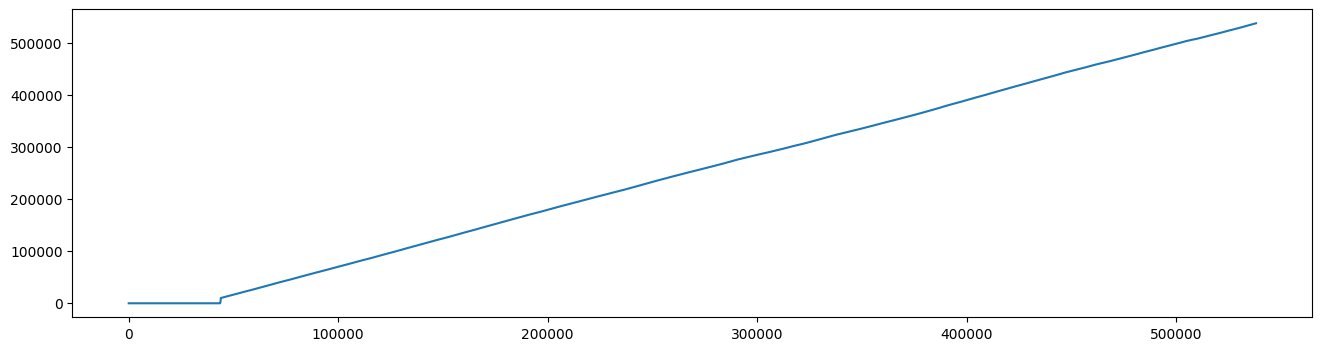

In [10]:
plt.figure(figsize=(16, 4))
plt.plot(t.sort_values().to_numpy())

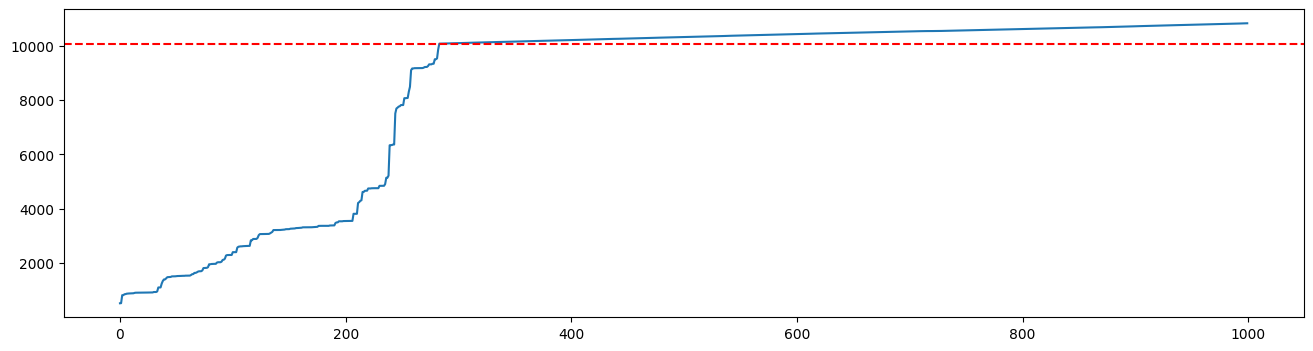

In [11]:
plt.figure(figsize=(16, 4))
plt.plot(t[t >= 0].sort_values().iloc[:1000].to_numpy())
plt.axhline(10080, color='r', linestyle='--')

I think the rows that do not have a close match in the old dataset are likely the most recent ones.

In [12]:
t -= 10080
t[t < 0] = 538149  # the most recent rows now have the biggest value

t = t.sort_values()
t[t <= len(t)] = np.arange(t[t <= len(t)].shape[0])
t = t.sort_index()

In [13]:
t = pd.Series(np.arange(538150), index=t.to_numpy()).sort_index()

Finally, sort the test dataset by time:

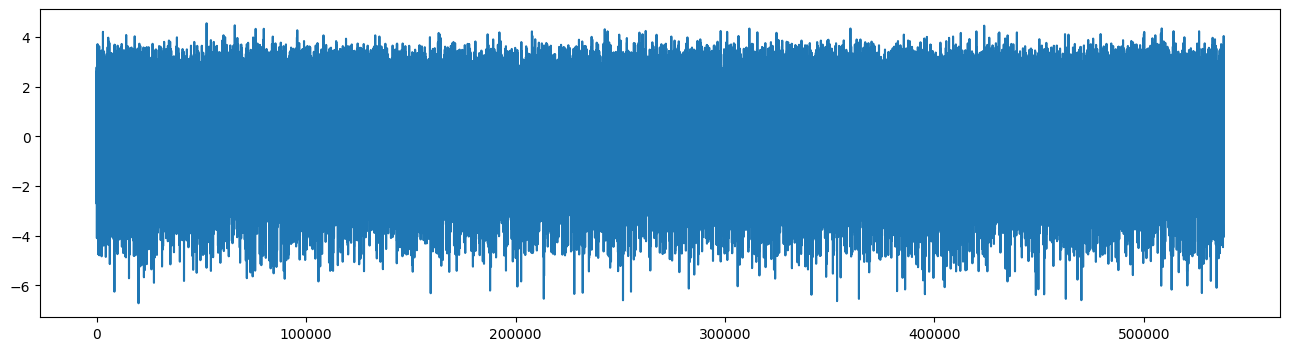

In [14]:
plt.figure(figsize=(16, 4))
plt.plot(test_df['X656'].to_numpy())

In [15]:
test_df = test_df.iloc[t.to_numpy()]

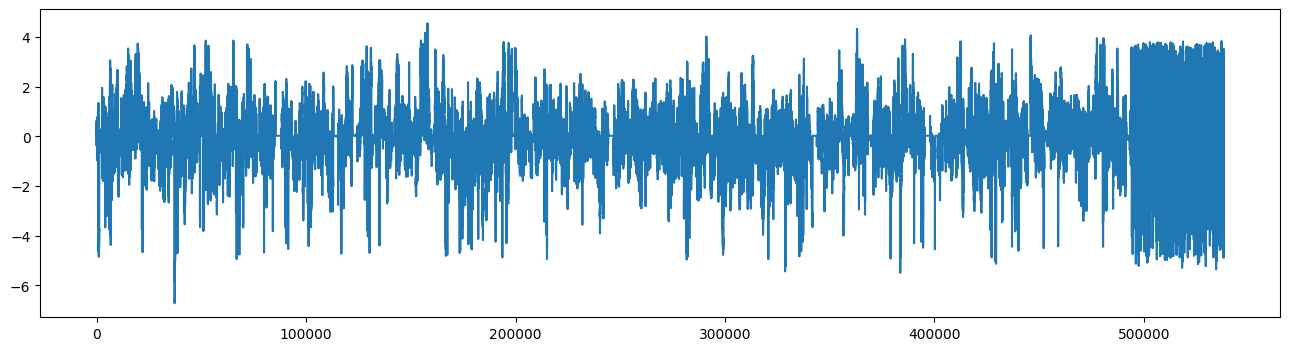

In [16]:
plt.figure(figsize=(16, 4))
plt.plot(test_df['X656'].to_numpy())

Preprocess the test dataset and perform model inference:

In [17]:
X_test, _ = preprocess_data(test_df)
test_df = None
print(X_test.shape)

(538150, 84)


In [18]:
X_test.iloc[:, :] = scaler.transform(X_test)

In [19]:
y_pred = model.predict(X_test)

In [20]:
pd.Series(y_pred).describe()

count    538150.000000
mean          0.010672
std           0.844560
min         -12.376946
25%          -0.348970
50%           0.024045
75%           0.390268
max          14.179561
dtype: float64

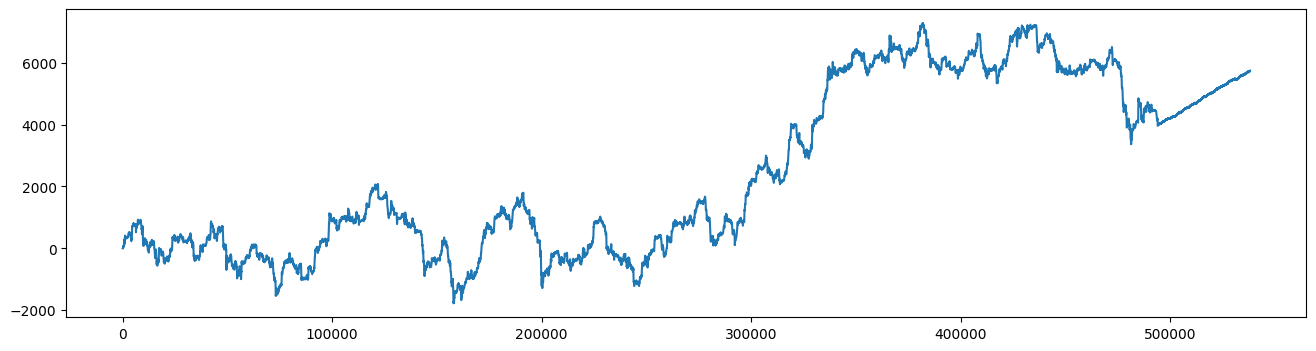

In [21]:
plt.figure(figsize=(16, 4))
plt.plot(np.cumsum(y_pred))

Save the predictions to the submission file:

In [22]:
submission = pd.read_csv('/kaggle/input/drw-crypto-market-prediction/sample_submission.csv')

submission = submission.iloc[t.to_numpy()]
submission['prediction'] = y_pred
submission = submission.sort_index()

submission.to_csv('submission.csv', index=False)

In [23]:
submission

,ID,prediction
0,1,0.009401
1,2,0.249108
2,3,-1.531455
3,4,-0.236115
4,5,-0.199162
...,...,...
538145,538146,-0.126254
538146,538147,0.079356
538147,538148,-1.370576
538148,538149,2.014246
